# Skip-gram (Implementation)

In this notebook, I implement the Skip-gram algorithm, which is a word2vec algorithm for calculating word embeddings. First, we must start off with some actual words data to train the CBOW model on. For this, I will use an excerpt from "Alice in Wonderland" by Lewis Carroll

## Motivation

One-hot encoding doesn't carry much meaning - word embeddings allow us to capture relationship between words.

In CBOW, we predict a target word based on context words.

In [64]:
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danieltiourine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Step 1: Prepare data

CBOW works by training a model to predict the target word based off of on the context word, allowing us to use the trained parameters as word embeddings. Thus, we must first prepare the words to be inputted into the neural network, so we need to one-hot encode. This entails a few main steps:

1. Prepare Corpus: We will use an excerpt from "Alice in Wonderland" by Lewis Carroll
2. One-hot encode each word in the vocabulary, resulting in a dictionary mapping from each word to a sparse vector.
2. Find the context for each word in the vocabulary, resulting in a dictionary mapping from each word to its context words.
3. One-hot encode the word-context dictionary using the word-onehot dictionary, resulting in a one-hot encoded word-context dictionary.

### Step 1.1: Prepare Corpus

In [50]:
corpus_path = 'corpus.txt'
with open(corpus_path, 'r', encoding='utf-8') as f:
    corpus = f.read()

print("Corpus:")
print(corpus)

Corpus:
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?'

So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.

There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, 'Oh dear! Oh dear! I shall be late!' (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at i

In [51]:
# Preprocess words (lowercase, remove punctuation, tokenization)

# Sample preprocessed text
corpus = corpus.lower()

# Remove punctuation
translator = str.maketrans('', '', string.punctuation)
corpus = corpus.translate(translator)

# Tokenize the text
tokenized_corpus = word_tokenize(corpus)

# Create vocabulary
vocabulary = set(tokenized_corpus)

print("Vocabulary:", vocabulary)
print("Number of unique words:", len(vocabulary))

Vocabulary: {'fortunately', 'burning', 'rabbit', 'of', 'at', 'curiosity', 'whether', 'as', 'when', 'actually', 'could', 'hear', 'for', 'pleasure', 'see', 'on', 'to', 'shall', 'and', 'would', 'watch', 'think', 'by', 'oh', 'eyes', 'just', 'occurred', 'making', 'suddenly', 'own', 'wondered', 'twice', 'started', 'afterwards', 'itself', 'ought', 'with', 'its', 'feel', 'pictures', 'made', 'reading', 'rabbithole', 'took', 'but', 'having', 'is', 'waistcoatpocket', 'this', 'her', 'feet', 'that', 'in', 'out', 'what', 'mind', 'up', 'considering', 'remarkable', 'i', 'without', 'much', 'get', 'white', 'she', 'thought', 'hurried', 'was', 'so', 'use', 'sleepy', 'or', 'trouble', 'well', 'field', 'have', 'pop', 'there', 'book', 'either', 'under', 'worth', 'sister', 'pink', 'down', 'it', 'conversation', 'quite', 'after', 'take', 'across', 'a', 'very', 'hot', 'tired', 'over', 'ever', 'do', 'did', 'then', 'into', 'dear', 'daisies', 'all', 'natural', 'peeped', 'looked', 'no', 'ran', 'picking', 'conversatio

### Step 1.2: Retrieve Word-Context Pairs

(Since in CBOW we are trying to predict the center word based on context words, we first need to define which context words correlate to each word. )
In addition to encoding each word, we must also retrieve the contexts of each word. We do this by finding the surrounding words of the target word in different sentences, defined by some window size. Let's choose a window size of 4.

The below code creates a dictionary where each key is a word and its corresponding object is the context words.

In [52]:
window_size = 2
def build_word_context_pairs(tokenized_corpus=tokenized_corpus, vocabulary=vocabulary, window_size=window_size):
    word_context_pairs = {word: [] for word in vocabulary}
    
    for index, target_word in enumerate(tokenized_corpus):
        if target_word in vocabulary:
            start_index = max(index - window_size, 0)
            end_index = min(index + window_size + 1, len(tokenized_corpus))
            
            context_words = [tokenized_corpus[i] for i in range(start_index, end_index) if i != index]
            word_context_pairs[target_word].extend(context_words)
            
    return word_context_pairs
    
word_context_pairs = build_word_context_pairs()     
print("Context pairs for 'alice':", word_context_pairs['alice'])
print("Context pairs for 'natural':", word_context_pairs['natural'])
print("Context pairs for 'conversations':", word_context_pairs['conversations'])

Context pairs for 'alice': ['was', 'beginning', 'book', 'thought', 'without', 'pictures', 'nor', 'did', 'think', 'it', 'hurried', 'on', 'started', 'to']
Context pairs for 'natural': ['seemed', 'quite', 'but', 'when']
Context pairs for 'conversations': ['pictures', 'or', 'in', 'it']


### Step 1.3: Encode Words
Now that we have prepared our vocabulary into words to context pairs, let's encode these words so they be fed into the model. Instead of traditional one-hot-encoding, word2vec typically uses more efficient representation due to the high computational costs associated with handling large vocabularies. In this case, we will use index mapping. We do this so the data can be converted to a numerical form that can be understood by neural networks.

In [53]:
def create_index_mapping(vocabulary):
    word_to_index = {word: i for i, word in enumerate(vocabulary)}
    index_to_word = {i: word for word, i in word_to_index.items()}
    return word_to_index, index_to_word

word_to_index, index_to_word = create_index_mapping(vocabulary)

### Step 1.4: Set up training data
Now that we have encoded our word-context pairs, we can use this to set up the training data.

In [54]:
def get_training_data(word_context_pairs, word_to_index):
    """
    
    :param word_context_pairs: list of 
    :param word_to_index: 
    :return: 
    """
    training_data = []
    for word, contexts in word_context_pairs.items():
        word_idx = word_to_index[word]
        context_indices = [word_to_index[context] for context in contexts]
        for context_idx in context_indices:
            training_data.append((word_idx, context_idx))
    return np.array(training_data, dtype='int32')

training_data = get_training_data(word_context_pairs, word_to_index)
print(training_data[0:10])

[[ 0 85]
 [ 0 18]
 [ 0 67]
 [ 0 25]
 [ 1 85]
 [ 1 18]
 [ 1 36]
 [ 1  5]
 [ 2 91]
 [ 2 63]]


## Step 2: Define and Train Model

Now that we have encoded word-context pairs (for example (21, 3), (68, 7), (21, 10), (42, 18)), where the left integer is an encoded target word and the right integer is one of its encoded context words, we can use this data to train a model to predict relationships. We do this through a technique called **negative sampling**, involving:
- First, a true pair is fed to the model (e.g (21, 3), where 21 is the target and 3 is a true context). 
- Second, we also sample other words from the vocabulary that act as 'negative' examples. These are words that are not in the actual context of the target word. So for example, say we sample the words represented by 10, 7, and 18, then we would have (21, 10), (21, 7), and (21, 18), where these pairs are not actual contexts.
- Third, the model is tasked to distinguish between the real (positive) pairs and the fake (negative) pairs. It must learn to identify that (21, 3) is an actual word-context pair while the others are not. It should learn to predict high probabilities for actual context words and low probabilities for the negative samples.
- Fourth, note that the model does this by optimizing a binary classification objective, where the model predicts whether a given pair is likely to be a true contextual relationship or not. The model adjusts its parameters to maximize the likelihood of true context words and minimize the likelihood of the negative samples. This effectively trains the model's embeddings to capture meaningful semantic relationships between words.

Motivation: By using negative sampling in this way, we are able to make training more computationally efficient. Instead of guessing the correct context word among all vocabulary words, it has a smaller subset to choose from. It's sort of like giving the model a multiple choice quiz.


In [55]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.output_layer = nn.Linear(embedding_dim, 1)
        
    def forward(self, word_indices):
        embeds = self.embedding(word_indices)
        out = self.output_layer(embeds)
        probabilities = torch.sigmoid(out)
        return probabilities

Let's walk through the architecture of the model to better understand it:
- **Embedding Layer**: The embedding layer's primary role is to learn a dense, lower-dimensional representation of words. You can think of it as a lookup table, where the index associated with each word corresponds to a row in the matrix of parameters (the embedding matrix). This row gives us the word embedding of the corresponding word. Mathematically, :

In [56]:
vocab_size = len(vocabulary)
embedding_dim = 100
model = SkipGramModel(vocab_size, embedding_dim)

In [57]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [73]:
num_epochs = 500

for epoch in range(num_epochs):
    total_loss = 0
    for context, target in training_data:
        # Zero the gradients
        model.zero_grad()

        # Forward pass
        # Ensure context is wrapped in a tensor and has the correct shape
        log_probs = model(torch.tensor([context], dtype=torch.long))

        # Compute loss
        # Ensure target is a float tensor and reshaped to match the output dimensions
        loss = loss_function(log_probs, torch.tensor([float(target)], dtype=torch.float).unsqueeze(1))

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if epoch % 25 == 0:    
        print(f"Epoch {epoch}, Loss: {total_loss}")

Epoch 0, Loss: -63730.65815329552
Epoch 25, Loss: -63730.81734025478
Epoch 50, Loss: -63730.887006014585
Epoch 75, Loss: -63730.92719492316
Epoch 100, Loss: -63730.95431765914
Epoch 125, Loss: -63730.9735519886
Epoch 150, Loss: -63730.98859065771
Epoch 175, Loss: -63731.00005155802
Epoch 200, Loss: -63731.00945469737
Epoch 225, Loss: -63731.01697540283
Epoch 250, Loss: -63731.02376639843
Epoch 275, Loss: -63731.029478788376
Epoch 300, Loss: -63731.03399050236
Epoch 325, Loss: -63731.03847512603
Epoch 350, Loss: -63731.04235470295
Epoch 375, Loss: -63731.045588344336
Epoch 400, Loss: -63731.04929819703
Epoch 425, Loss: -63731.051873236895
Epoch 450, Loss: -63731.05429679155
Epoch 475, Loss: -63731.05685091019


## Step 3: Get Word Embeddings
Now that our model has finished training, we should be able to extract the word embeddings for our vocabulary by using the parameters of the model.

In [60]:
# Retrieve the embeddings from the model's embedding layer
embeddings = model.embedding.weight.data.numpy()
print("Embedding shape:", embeddings.shape)

Embedding shape: (136, 100)


In [67]:
alice_index = word_to_index["alice"]
alice_embedding = model.embedding.weight.data[alice_index].numpy()  # Convert tensor to numpy array for easy handling
print("Embedding for 'alice':", alice_embedding)

Embedding for 'alice': [-1.0557172e+00 -2.7104780e-01 -1.3501444e+00 -3.9735541e-01
 -1.2445731e+00  3.8718826e-01 -2.2616054e-01  2.5190222e-01
 -1.4604144e+00  9.6839130e-01  4.9872300e-01  1.2886710e-02
 -8.4232932e-01  2.2475544e-01  1.2376552e+00  3.5282278e-01
  3.2939553e-01 -6.1935771e-01  8.9220041e-01  5.8776051e-01
 -5.0994432e-01 -1.9969079e-01 -5.8027387e-01  6.5721565e-01
 -1.1485481e+00  9.9619949e-01  4.0879911e-01  8.3821517e-01
  9.7668844e-01  1.4329723e-01  9.1755456e-01 -9.6365684e-01
 -3.9094624e-01  4.1254735e-01 -8.0253726e-01 -8.0439907e-01
 -9.5406368e-02 -5.0671160e-01 -2.7281088e-01  8.1396830e-01
  3.0354036e-02 -3.6650875e-01  6.1870849e-01 -2.1339358e-01
  7.3075928e-02  8.0186760e-01  6.4397687e-01 -8.9972377e-01
 -1.1866559e+00  1.0554802e-01 -1.2559911e+00  1.6914433e-01
 -9.5039654e-01 -5.2574760e-01 -9.7859961e-01 -1.9235584e+00
  6.2239605e-01 -7.4843234e-01  5.4803807e-01 -3.1975451e-01
  1.7139661e+00  1.0535793e+00  1.0965325e+00 -7.9724896e-01
 

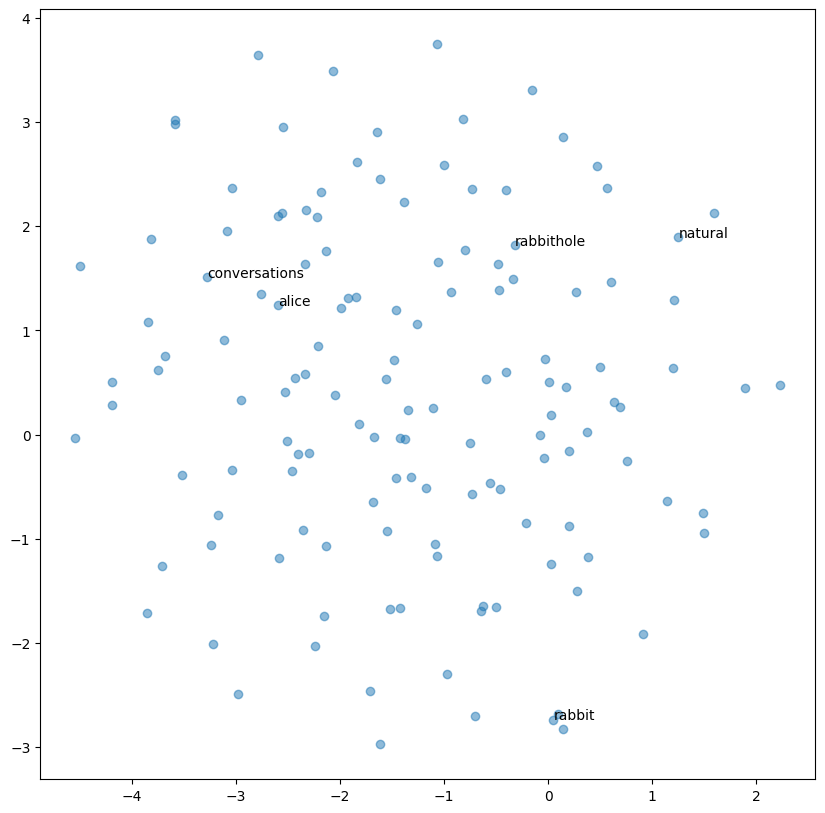

In [71]:
# Perform t-SNE dimensionality reduction to visualize embedding space
tsne = TSNE(n_components=2, perplexity=30, max_iter=3000)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

# Annotate a few interesting words
words = ['alice', 'natural', 'conversations', 'rabbit', 'rabbithole'] 
for word in words:
    if word in word_to_index: 
        idx = word_to_index[word]
        plt.annotate(word, (embeddings_2d[idx, 0], embeddings_2d[idx, 1]))

plt.show()

In [72]:
from sklearn.metrics.pairwise import cosine_similarity

def find_nearest_neighbors(word, embeddings, word_to_index, index_to_word, top_n=5):
    word_index = word_to_index[word]
    word_embedding = embeddings[word_index].reshape(1, -1)
    similarities = cosine_similarity(word_embedding, embeddings).flatten()
    nearest_indices = similarities.argsort()[-top_n-1:-1][::-1]  # Skip the word itself
    nearest_words = [(index_to_word[idx], similarities[idx]) for idx in nearest_indices]
    return nearest_words

# Example usage:
neighbors = find_nearest_neighbors('alice', embeddings, word_to_index, index_to_word)
print("Nearest Neighbors of 'alice':", neighbors)

Nearest Neighbors of 'alice': [('made', 0.2458941), ('pink', 0.23651879), ('tired', 0.21291341), ('peeped', 0.20657542), ('she', 0.1992316)]


## Conclusion

We have successfully implemented the Skip-gram word2vec algorithm, capturing information of words in a numerical format.